# Import all libraries

In [2]:
import numpy as np
import torch
import networkx as nx
from tqdm import tqdm

from Architecture.Layers import ChaoticRNN
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    !nvidia-smi
    print(torch.cuda.get_device_name(0))

else:
    print("No GPU :(")

Sun Apr 30 01:33:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti      Off| 00000000:01:00.0  On |                  N/A |
| N/A   50C    P0               26W /  N/A|    833MiB /  4096MiB |     54%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
device = torch.device('cpu')

In [5]:
from sklearn.metrics import f1_score, accuracy_score

def validate(model, valid_batch_loader):
    # Create empty lists to store predictions and labels
    predictions = []
    labels = []

    # Iterate over validation set
    for i, (features, ans) in tqdm(enumerate(valid_batch_loader), total=len(valid_batch_loader), desc='Validation', leave=True, colour='green'):

        # Get one-hot encoded label
        ans = torch.eye(output_size)[ans]

        # Forward pass
        Y_pred, time = model.forward(features.view(-1, input_size), return_work_time=True)

        # Get prediction
        prediction = torch.argmax(Y_pred, dim=0).item()

        # Append to lists
        predictions.append(prediction)
        labels.append(torch.argmax(ans.view(-1, output_size), dim=1).item())

    # Calculate metrics
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return f1, acc

# Load MNIST

In [6]:
import torchvision
dataset = torchvision.datasets.MNIST(root = 'datasets', train = True, download = True, transform=torchvision.transforms.ToTensor())

#### Get and visualize random individual

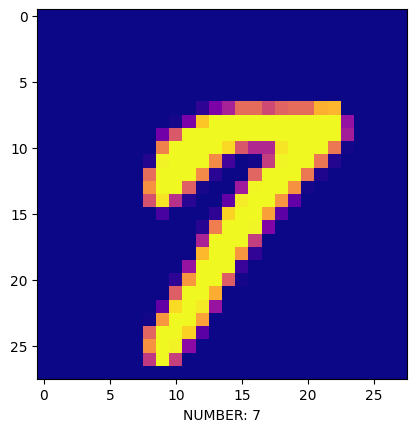

In [7]:
rand_individ = np.random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]
plt.imshow(img, cmap='plasma')
plt.xlabel(f"NUMBER: {ans}")
plt.show()

# Prepare and split data into train/test

In [8]:
split_ratio = 0.99
batch_size = 1
train_size = round(len(dataset) * split_ratio)
valid_size = len(dataset) - train_size

print(dataset)

train, valid = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Encode labels from MNIST to one-hot
train_batch_loader = torch.utils.data.DataLoader2(train, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))
valid_batch_loader = torch.utils.data.DataLoader2(valid, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: ToTensor()


# Configure NN Model and hyper-parameters

In [9]:
input_size = 28*28
hidden_size = 100
output_size = 10

model = ChaoticRNN(input_size, output_size, hidden_size, connect_percentage=0.0).to(device)

print(f'nodes: {len(model.graph.nodes)}\n edges: {len(model.graph.edges)}')

nodes: 894
 edges: 991


In [10]:
f1, acc = validate(model, valid_batch_loader)
print(f'Metrics without training:\nF1: {f1}\nACC: {acc}')

Validation: 100%|██████████| 600/600 [00:36<00:00, 16.59it/s]

Metrics without training:
F1: 0.0919720273619961
ACC: 0.17833333333333334


# Train loop

In [11]:
# Configure hyper-parameters
epochs = 1
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = []
loss_accomulator = []

In [16]:
for epoch in range(0, epochs):
    for i, (features, ans) in enumerate(tqdm(train_batch_loader, desc=f"Epoch {epoch + 1}", leave=False, colour='green')):

        # Forward pass
        Y_pred = model.forward(features.view(-1, input_size)).to(device)
        # print(Y_pred, ans)

        # Calculate loss
        ans = torch.eye(output_size)[ans]
        loss = loss_func(Y_pred.view(-1, ), ans.view(-1, ))

        # Backward pass
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())
        if i % 50 == 0:
            history.append(np.mean(loss_accomulator))
            loss_accomulator = []

KeyboardInterrupt: 

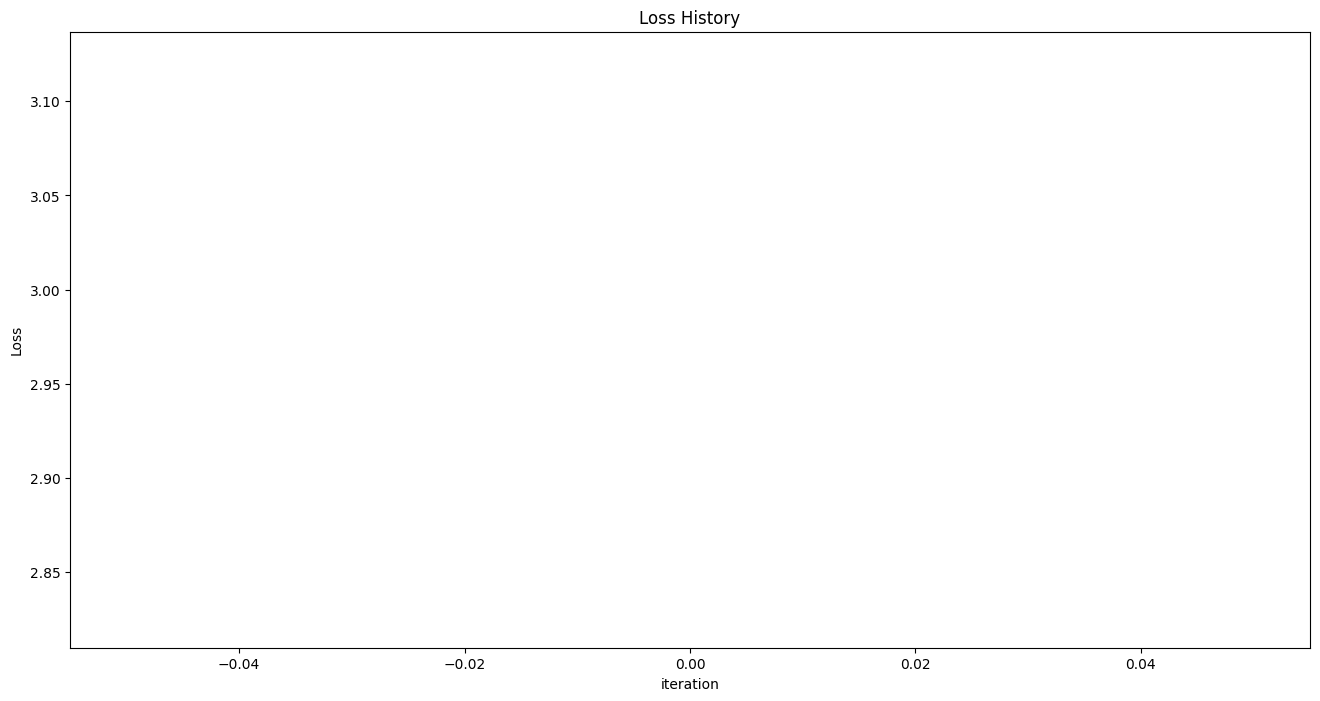

In [17]:
# Plot loss history
plt.figure(figsize=(16, 8))
plt.plot(history)
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()

# Validate trained model

In [18]:
f1, acc = validate(model, valid_batch_loader)
print(f'Metrics without training:\nF1: {f1}\nACC: {acc}')

Validation:  60%|█████▉    | 358/600 [00:20<00:13, 17.35it/s]


KeyboardInterrupt: 

# Visualisation test

In [ ]:
rand_individ = np.random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]


with torch.no_grad():
    pred = model.forward(img.view(-1, input_size)).to(device)

plt.imshow(img, cmap='Greys')
plt.xlabel(f"PREDICTION: {pred}, ANSWER {ans}")
pass